<b>Autonecoder tutorial:</b>
https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial9/AE_CIFAR10.html
</br>
<b>Deep Clustering with Convolutional Autoencoders paper:</b>
https://xifengguo.github.io/papers/ICONIP17-DCEC.pdf

In [17]:
# directory name of dataset
DATASET_NAME = "music_audio_benchmark"

# feature name (spectogram, mel_spectogram, chromagram)
FEATURE_NAME = "mel_spectogram"

In [18]:
import os
import numpy as np
import pandas as pd
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

from torch.utils.data import Dataset

from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard

import torchvision
from torchvision import transforms

import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Import from file (fix num_workers problem)
from FeaturesDataset import FeaturesDataset
from FeaturesDataset import load_img
from FeaturesDataset import WIDTH
from FeaturesDataset import HEIGHT

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Properly utilize Tensor Cores
torch.set_float32_matmul_precision("high")

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

CHECKPOINT_PATH = "../checkpoints"

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Seed set to 42


Device: cuda:0


In [19]:
checkpoints_path = f"{CHECKPOINT_PATH}/{DATASET_NAME}"
if not os.path.exists(checkpoints_path):
    print("CREATING CHECKPOINT FOLDER FOR MODELS")
    os.makedirs(checkpoints_path)

## Load data

In [20]:
def load_numpy_array(path):
    return np.load(path)

# TODO: not resize here, save file with right width and height
# def load_img(path):
#     image = Image.open(path)
#     image = image.resize((32, 32))
#     return np.array(image)


def get_first_n_images(dataset, n):
    return torch.stack([dataset[i] for i in range(n)], dim=0)


# class FeaturesDataset(Dataset):
#     def __init__(self, paths, transform=None):
#         self.paths = paths
#         self.transform = transform
        
#     def __len__(self):
#         return len(self.paths)
    
#     def __getitem__(self, idx):
#         path = self.paths[idx]
#         feature = load_img(path)
#         if self.transform:
#             feature = self.transform(feature)
#         return feature

### Path to images

In [21]:
project_dir = os.path.relpath(os.path.join(os.getcwd(), os.pardir))
features_dir = os.path.join(project_dir, "features")

#TODO: argument for dataset folder name
dataset_dir = os.path.join(features_dir, DATASET_NAME)

csv_file_name = "features.csv"
csv_file_path = os.path.join(dataset_dir, csv_file_name)

df = pd.read_csv(csv_file_path)
path_columns = [
    'name', 'path_spectogram_arr', 'path_mel_spectogram_arr', 'path_chromagram_arr', 'path_mfccs_arr', 
    'path_spectogram_img',  'path_mel_spectogram_img', 'path_chromagram_img', 'label'
]

df_paths = df[path_columns].copy()
feature = f'path_{FEATURE_NAME}_img'
features_paths = df_paths[feature].values

In [22]:
WIDTH

64

### Train and validation datasets

In [23]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, ))
])
transform2 = transforms.Compose([transforms.ToTensor()])

feature_dataset = FeaturesDataset(features_paths, transform=transform)

train_length = int(0.8 * len(feature_dataset))
val_length = len(feature_dataset) - train_length
train_set, val_set = torch.utils.data.random_split(feature_dataset, [train_length, val_length])

train_loader = data.DataLoader(train_set, batch_size=64, shuffle=True, drop_last=True, pin_memory=True, num_workers=8, persistent_workers=True)
val_loader = data.DataLoader(val_set, batch_size=64, shuffle=False, drop_last=True, num_workers=8, persistent_workers=True)

### Validate if images are correctly loaded

In [24]:
def compare_imgs(img1, img2, title=""):
    loss = F.mse_loss(img1, img2, reduction="sum")
    
    grid = torchvision.utils.make_grid(torch.stack([img1, img2], dim=0), nrow=2, normalize=True, value_range=(-1, 1))
    grid = grid.permute(1, 2, 0)
    
    plt.figure(figsize=(12, 6))
    plt.title(f"{title}, Loss: {loss.item():4.2f}")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

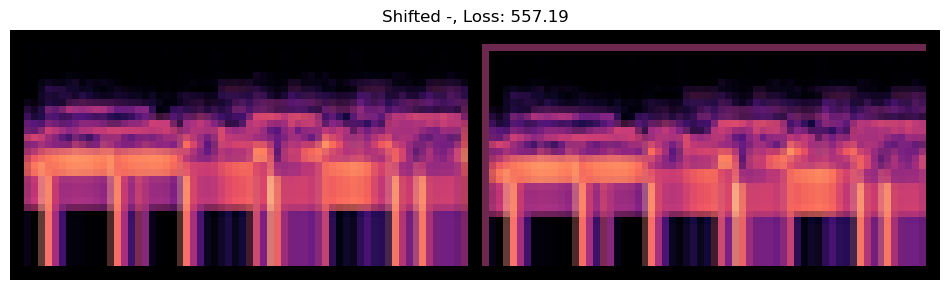

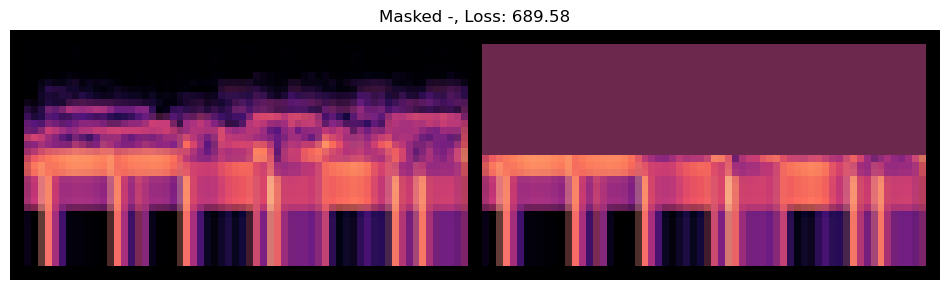

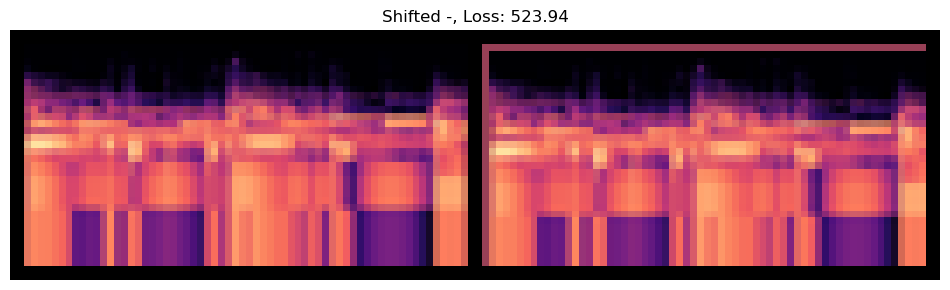

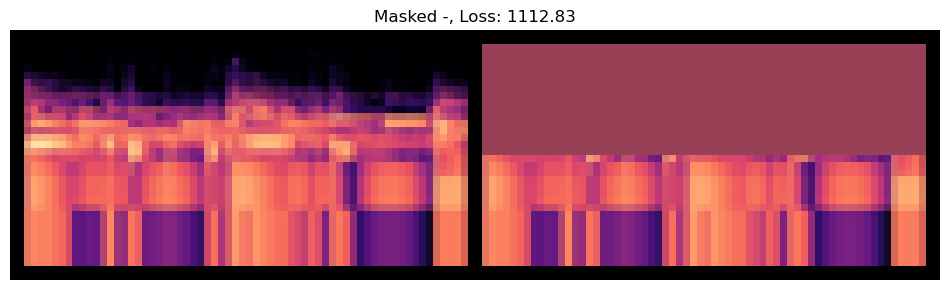

In [25]:
for i in range(2):
    # Load example image
    img = feature_dataset[i]
    img_mean = img.mean(dim=[1, 2], keepdims=True)

    # Shift image by one pixel
    SHIFT = 1
    img_shifted = torch.roll(img, shifts=SHIFT, dims=1)
    img_shifted = torch.roll(img_shifted, shifts=SHIFT, dims=2)
    img_shifted[:,:1,:] = img_mean
    img_shifted[:,:,:1] = img_mean
    compare_imgs(img, img_shifted, "Shifted -")

    # Set half of the image to zero
    img_masked = img.clone()
    img_masked[:,:img_masked.shape[1]//2,:] = img_mean
    compare_imgs(img, img_masked, "Masked -")

## Autoencoder

In [26]:
# TODO:
# 1. try other activation_fns
# 2. change comments to proper sizes
# 3. change values to proper sizes

class Encoder(nn.Module):
    """
    Inputs: 
        - num_input_channels : Number of input channels of the image.
        - base_channel_size : Number of channels we use in the first convolutional layers. Deeper layers might use a duplicate of it.
        - latent_dim : Dimensionality of latent representation z
        - activation_fn : Activation function used throughout the encoder network
    """
    def __init__(
        self,
        num_input_channels: int,
        base_channel_size: int,
        latent_dim: int,
        activation_fn: object = nn.GELU
    ): 

        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(num_input_channels, base_channel_size, kernel_size=3, padding=1, stride=2), # 128x64 -> 64x32
            activation_fn(),
            nn.Conv2d(base_channel_size, base_channel_size, kernel_size=3, padding=1),
            activation_fn(),
            nn.Conv2d(base_channel_size, 2 * base_channel_size, kernel_size=3, padding=1, stride=2), # 64x32 -> 32x16
            activation_fn(),
            nn.Conv2d(2 * base_channel_size, 2 * base_channel_size, kernel_size=3, padding=1),
            activation_fn(),
            nn.Conv2d(2 * base_channel_size, 2 * base_channel_size, kernel_size=3, padding=1, stride=2), # 32x16 -> 16x8
            activation_fn(),
            nn.Flatten(), # flatten to single feature vector
            nn.Linear(2 * base_channel_size * (WIDTH // 8) * (HEIGHT // 8), latent_dim)
        )
    
    def forward(self, x):
        return self.net(x)

In [27]:
# TODO:
# 1. try other activation_fns
# 2. change comments to proper sizes
# 3. change values to proper sizes
class Decoder(nn.Module):
    """
    Inputs: 
        - num_input_channels : Number of input channels of the image.
        - base_channel_size : Number of channels we use in the first convolutional layers. Deeper layers might use a duplicate of it.
        - latent_dim : Dimensionality of latent representation z
        - activation_fn : Activation function used throughout the encoder network
    """
    def __init__(
        self,
        num_input_channels: int,
        base_channel_size: int,
        latent_dim: int,
        activation_fn: object = nn.GELU
    ): 

        super().__init__()
        self.linear = nn.Sequential(
            nn.Linear(latent_dim, 2 * base_channel_size * (WIDTH // 8) * (HEIGHT // 8)),
            activation_fn()
        )
        self.net = nn.Sequential(
            nn.ConvTranspose2d(2 * base_channel_size, 2 * base_channel_size, kernel_size=3, output_padding=1, padding=1, stride=2), # 16x8 -> 32x16
            activation_fn(),
            nn.Conv2d(2 * base_channel_size, 2 * base_channel_size, kernel_size=3, padding=1),
            activation_fn(),
            nn.ConvTranspose2d(2 * base_channel_size, base_channel_size, kernel_size=3, output_padding=1, padding=1, stride=2), # 32x16 -> 64x32
            activation_fn(),
            nn.Conv2d(base_channel_size, base_channel_size, kernel_size=3, padding=1),
            activation_fn(),
            nn.ConvTranspose2d(base_channel_size, num_input_channels, kernel_size=3, output_padding=1, padding=1, stride=2), # 64x32 -> 128x64
            nn.Tanh() # TODO: scale images between -1 and 1
        )
    
    def forward(self, x):
        x = self.linear(x)
        x = x.reshape(x.shape[0], -1, (HEIGHT // 8), (WIDTH // 8)) # reshape tensor (spatial dimensions set to 16x8)
        x = self.net(x)
        return x

In [28]:
# TODO:
# 1. change values to proper sizes
# 2. try different loss functions

class Autoencoder(pl.LightningModule):
    """
    Inputs: 
        - base_channel_size : Number of channels we use in the first convolutional layers. Deeper layers might use a duplicate of it.
        - latent_dim : Dimensionality of latent representation z
        - encoder_class : Encoder
        - decoder_class : Decoder
        - num_input_channels : Number of input channels of the image.
        - width : Image width.
        - height : Image height.
    """
    def __init__(
        self,
        base_channel_size: int,
        latent_dim: int,
        encoder_class: object = Encoder,
        decoder_class: object = Decoder,
        num_input_channels: int = 3,
        width: int = WIDTH,
        height: int = HEIGHT
    ):
        super().__init__()
        
        # Save hyperparameters
        self.save_hyperparameters()
        
        self.encoder = encoder_class(num_input_channels, base_channel_size, latent_dim)
        self.decoder = decoder_class(num_input_channels, base_channel_size, latent_dim)
        
        # Example input array needed for visualizing the graph of network
        self.example_input_array = torch.zeros(2, num_input_channels, width, height)
        
    """
    The forward function takes in an image and returns the reconstructed image
    """
    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat
    
    """
    Given a batch of images, this function returns the reconstruction loss (MSE in our case)
    """
    def _get_recontruction_loss(self, batch):
        x = batch
        x_hat = self.forward(x)
        
        loss = F.mse_loss(x, x_hat, reduction="none")
        loss = loss.sum(dim=[1, 2, 3]).mean(dim=[0])
        return loss
    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        
        # The scheduler reduces the LR if the validation performance hasn't improved for the last N epochs
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode="min",
            factor=0.2,
            patience=20,
            min_lr=5e-5
        )
        
        return {
            "optimizer": optimizer,
            "lr_scheduler": scheduler,
            "monitor": "val_loss"
        }
    
    def training_step(self, batch, batch_idx):
        loss = self._get_recontruction_loss(batch)
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        loss = self._get_recontruction_loss(batch)
        self.log('val_loss', loss)
        
    def test_step(self, batch, batch_idx):
        loss = self._get_recontruction_loss(batch)
        self.log('test_loss', loss)

In [29]:
autoencoder_arch = Autoencoder(base_channel_size=3, latent_dim=32)
print(autoencoder_arch)

Autoencoder(
  (encoder): Encoder(
    (net): Sequential(
      (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): GELU(approximate='none')
      (2): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): GELU(approximate='none')
      (4): Conv2d(3, 6, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (5): GELU(approximate='none')
      (6): Conv2d(6, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): GELU(approximate='none')
      (8): Conv2d(6, 6, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (9): GELU(approximate='none')
      (10): Flatten(start_dim=1, end_dim=-1)
      (11): Linear(in_features=192, out_features=32, bias=True)
    )
  )
  (decoder): Decoder(
    (linear): Sequential(
      (0): Linear(in_features=32, out_features=192, bias=True)
      (1): GELU(approximate='none')
    )
    (net): Sequential(
      (0): ConvTranspose2d(6, 6, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_p

In [30]:
class GenerateCallback(pl.Callback):
    def __init__(self, imgs, every_n_epochs=5):
        super().__init__()
        self.imgs = imgs # Images to reconstruct
        self.every_n_epochs = every_n_epochs
        
    def on_train_epoch_end(self, trainer, pl_module):
        if trainer.current_epoch % self.every_n_epochs == 0:
            # Reconstruct images
            imgs = self.imgs.to(pl_module.device)
            with torch.no_grad():
                pl_module.eval()
                reconst_imgs = pl_module(imgs)
                pl_module.train()
            
            images = torch.stack([imgs, reconst_imgs], dim=1).flatten(0, 1)
            grid = torchvision.utils.make_grid(images, nrow=2, normalize=True, value_range=(-1, 1))
            trainer.logger.experiment.add_image("Reconstructions", grid, global_step=trainer.global_step)

In [31]:
def train_ae(latent_dim):
    checkpoint_callback = ModelCheckpoint(
        monitor="val_loss",
        mode="min",
        save_top_k=1,
        save_weights_only=True
    )
    
    trainer = pl.Trainer(
        default_root_dir=os.path.join(CHECKPOINT_PATH, f"{DATASET_NAME}/{latent_dim}-{FEATURE_NAME}"),
        accelerator="gpu" if str(device).startswith("cuda") else "cpu",
        devices=1,
        max_epochs=100,
        callbacks=[
            checkpoint_callback,
            GenerateCallback(get_first_n_images(feature_dataset, 4), every_n_epochs=10),
            LearningRateMonitor("epoch")
        ]
    )
    
    trainer.logger._log_graph = True 
    trainer.logger._default_hp_metric = None 
    
    pretrained_filename = f"{CHECKPOINT_PATH}/{DATASET_NAME}/{latent_dim}-{FEATURE_NAME}"
    # TODO: EVEN IF PREATRAINED MODEL FOUND -> STILL TRAIN
    if os.path.isfile(pretrained_filename):
        print("FOUND PRETRAINED MODEL!")
#         model = Autoencoder.load_from_checkpoint(pretrained_filename)
#     else:
    model = Autoencoder(base_channel_size=32, latent_dim=latent_dim)
    trainer.fit(model, train_loader, val_loader)
    
    best_model_path = checkpoint_callback.best_model_path
    best_model = Autoencoder.load_from_checkpoint(best_model_path)
    
    val_result = trainer.test(best_model, val_loader, verbose=False)
    result = {"val": val_result}
    
    return best_model, result

In [32]:
model_dict = {}
# for latent_dim in [32, 64, 128, 256]:
for latent_dim in [64, 128]:
    model_id, result_id = train_ae(latent_dim)
    model_dict[latent_dim] = {
        "model": model_id,
        "result": result_id
    }

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ..\checkpoints\music_audio_benchmark\64\lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | In sizes       | Out sizes     
----------------------------------------------------------------------
0 | encoder | Encoder | 233 K  | [2, 3, 64, 32] | [2, 64]       
1 | decoder | Decoder | 235 K  | [2, 64]        | [2, 3, 32, 64]
----------------------------------------------------------------------
469 K     Trainable params
0         Non-trainable params
469 K     Total params
1.877     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ..\checkpoints\music_audio_benchmark\128\lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | In sizes       | Out sizes     
----------------------------------------------------------------------
0 | encoder | Encoder | 364 K  | [2, 3, 64, 32] | [2, 128]      
1 | decoder | Decoder | 366 K  | [2, 128]       | [2, 3, 32, 64]
----------------------------------------------------------------------
731 K     Trainable params
0         Non-trainable params
731 K     Total params
2.926     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

In [33]:
for latent_dim in model_dict:
    print(f"latent_dim: {latent_dim}")
    print(model_dict[latent_dim]["result"])

latent_dim: 64
{'val': [{'test_loss': 225.20413208007812}]}
latent_dim: 128
{'val': [{'test_loss': 166.1399688720703}]}


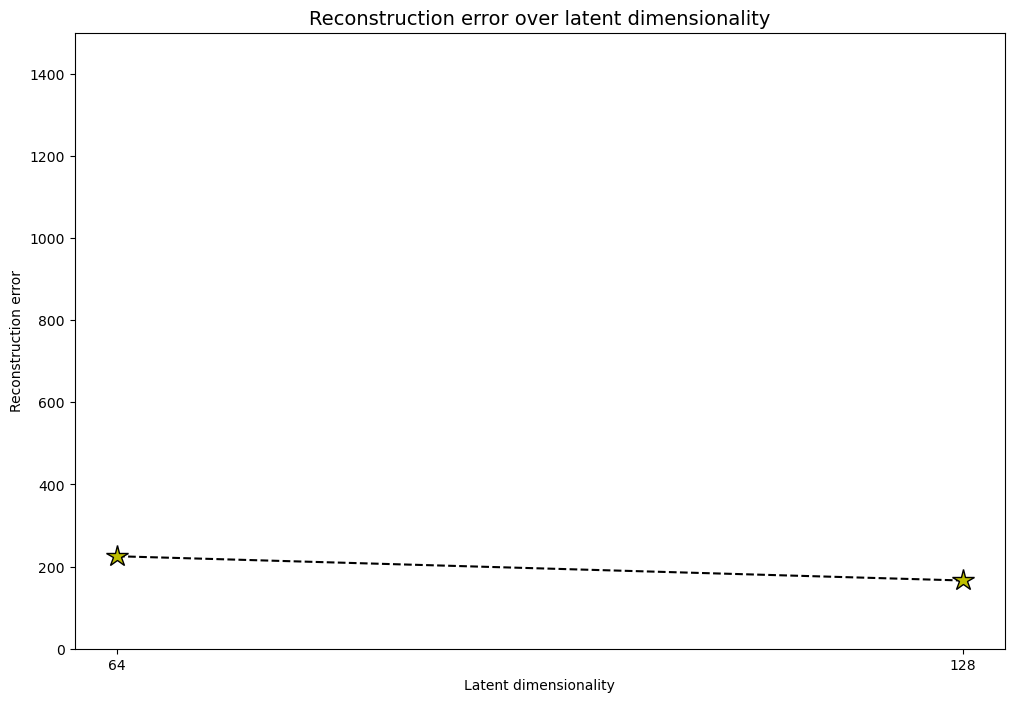

In [34]:
latent_dims = sorted([model for model in model_dict])
val_scores = [model_dict[latent_dim]["result"]["val"][0]["test_loss"] for latent_dim in latent_dims]

fig = plt.figure(figsize=(12, 8))
plt.plot(latent_dims, val_scores, '--', color="#000", marker="*", markeredgecolor="#000", markerfacecolor="y", markersize=16)
plt.xscale("log")
plt.xticks(latent_dims, labels=latent_dims)
plt.title("Reconstruction error over latent dimensionality", fontsize=14)
plt.xlabel("Latent dimensionality")
plt.ylabel("Reconstruction error")
plt.minorticks_off()
plt.ylim(0, 1500)
plt.show()

In [35]:
def visualize_reconstructions(model, input_imgs):
    # Reconstruct images
    model.eval()
    with torch.no_grad():
        reconst_imgs = model(input_imgs.to(model.device))
    reconst_imgs = reconst_imgs.cpu()
    
    # Plotting
    imgs = torch.stack([input_imgs, reconst_imgs], dim=1).flatten(0,1)
    grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=True, value_range=(-1,1))
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(12 , 8))
    plt.title(f"Reconstructed from {model.hparams.latent_dim} latents")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

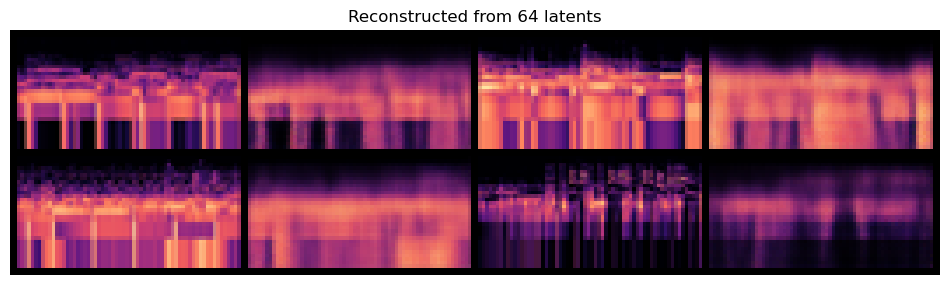

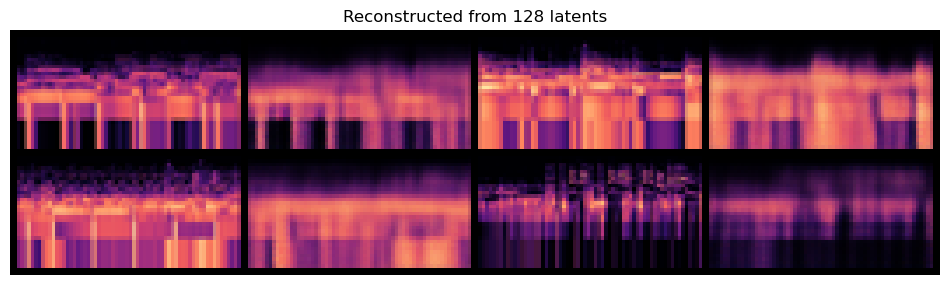

In [36]:
input_imgs = get_first_n_images(feature_dataset, 4)
for latent_dim in model_dict:
    visualize_reconstructions(model_dict[latent_dim]["model"], input_imgs)